Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 2000, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 128)            │         8,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,577 (33.50 KB)

 Trainable params: 8,577 (33.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 247ms/step - accuracy: 0.5879 - loss: 0.6860 - val_accuracy: 0.6250 - val_loss: 0.6171
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 231ms/step - accuracy: 0.8149 - loss: 0.5126 - val_accuracy: 0.7450 - val_loss: 0.4622
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 227ms/step - accuracy: 0.8285 - loss: 0.3961 - val_accuracy: 0.8900 - val_loss: 0.3013
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 221ms/step - accuracy: 0.9160 - loss: 0.3231 - val_accuracy: 0.9600 - val_loss: 0.2935
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 228ms/step - accuracy: 0.9580 - loss: 0.2309 - val_accuracy: 0.9400 - val_loss: 0.1636
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
Predykcja (1 = anomalia): 0.9683836


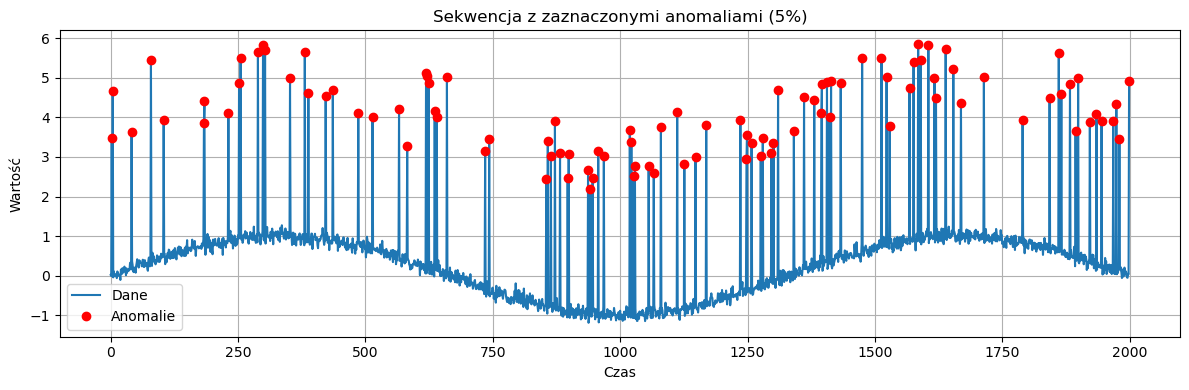

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, SimpleRNN, Dense
import matplotlib.pyplot as plt

# ===== Parametry danych =====
num_sequences = 1000
sequence_length = 2000

# ===== Zmodyfikowana funkcja generująca sekwencje i pozycję anomalii =====
def generate_sequence(with_anomaly=False):
    base = np.sin(np.linspace(0, 3 * np.pi, sequence_length)) + np.random.normal(0, 0.1, sequence_length)
    anomaly_positions = []
    if with_anomaly:
        num_anomalies = max(1, int(0.05 * sequence_length))  # 5% długości sekwencji
        anomaly_positions = np.random.choice(sequence_length, num_anomalies, replace=False)
        base[anomaly_positions] += np.random.uniform(3, 5, size=num_anomalies)
    return base, anomaly_positions

# ===== Tworzenie danych =====
X = []
y = []

for _ in range(num_sequences):
    if np.random.rand() < 0.5:
        seq, _ = generate_sequence(with_anomaly=False)
        X.append(seq)
        y.append(0)
    else:
        seq, _ = generate_sequence(with_anomaly=True)
        X.append(seq)
        y.append(1)

X = np.array(X).reshape(-1, sequence_length, 1)
y = np.array(y)

# ===== Model BRNN =====
inputs = Input(shape=(sequence_length, 1))
x = Bidirectional(SimpleRNN(64))(inputs)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# ===== Trening =====
model.fit(X, y, epochs=5, batch_size=32, validation_split=0.2)

# ===== Przykład predykcji i wykres =====
example_seq, anomaly_index = generate_sequence(with_anomaly=True)
example_input = example_seq.reshape(1, sequence_length, 1)
prediction = model.predict(example_input)
print("Predykcja (1 = anomalia):", prediction[0][0])

# ===== Wykres sekwencji z zaznaczonymi anomaliami =====
plt.figure(figsize=(12, 4))
plt.plot(example_seq, label='Dane sekwencyjne')
for idx in anomaly_index:
    plt.plot(idx, example_seq[idx], 'ro')  # każdy punkt anomalii
plt.title("Sekwencja z zaznaczonymi anomaliami (5%)")
plt.xlabel("Czas")
plt.ylabel("Wartość")
plt.legend(["Dane", "Anomalie"])
plt.grid(True)
plt.tight_layout()
plt.show()
